<a href="https://colab.research.google.com/github/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation/blob/main/lungsseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Git if not already installed
!apt-get install git -qq

# Configure Git with your info
!git config --global user.email "safinazmo7amed@gmail.com.com"
!git config --global user.name "Safinaz-Muhammad"

# Clone your GitHub repo (only once)
!git clone https://github.com/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation

fatal: destination path 'Task-1--Medical-Images-Segmentation' already exists and is not an empty directory.


In [ ]:
 from google.colab import files
 files.upload()  # upload kaggle.json here

# ========================
# 1. Setup Kaggle API
# ========================
!mkdir -p ~/.kaggle/ # Create the .kaggle directory if it doesn't exist
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ========================
# 2. Download + unzip datasets
# ========================
!mkdir -p ./datasets/lungs ./datasets/liver ./datasets/heart

# Lungs CT dataset
!kaggle datasets download -d kmader/finding-lungs-in-ct-data -p ./datasets/lungs --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data
License(s): unknown
 94% 991M/1.03G [00:23<00:03, 22.1MB/s]
100% 1.03G/1.03G [00:23<00:00, 46.3MB/s]


In [ ]:
# ========================
# 3. Common imports
# ========================
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import nibabel as nib # Import nibabel for .nii files

In [ ]:
# ========================
# 4. Preprocessing functions
# ========================
def load_and_preprocess_pil(image_path, target_size=(128,128)):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(target_size)
        return np.array(img) / 255.0
    except Exception as e:
        print(f"Error loading and preprocessing image {image_path}: {e}")
        return None

def load_and_preprocess_mask_pil(mask_path, target_size=(128,128)):
    try:
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize(target_size, Image.NEAREST)
        mask = np.array(mask)
        return (mask > 0).astype(np.uint8)
    except Exception as e:
        print(f"Error loading and preprocessing mask {mask_path}: {e}")
        return None

# ========================
# 5. Dataset loader (generic)
# ========================
def load_dataset(dataset_name):
    """
    dataset_name: "lungs", "liver", or "heart"
    """
    base_path = f"./datasets/{dataset_name}"

    # Depending on dataset, find images and masks
    if dataset_name == "lungs":
        img_dir = os.path.join(base_path, "2d_images")
        mask_dir = os.path.join(base_path, "2d_masks")
        image_extensions = (".png", ".jpg", ".tif")
        mask_extensions = (".png", ".jpg", ".tif")
    elif dataset_name == "liver":
        img_dir = os.path.join(base_path, "images")
        mask_dir = os.path.join(base_path, "annotation")
        image_extensions = (".png", ".jpg")
        mask_extensions = (".png", ".jpg")
    elif dataset_name == "heart":
        img_dir = os.path.join(base_path, "images")
        mask_dir = os.path.join(base_path, "data")
        image_extensions = (".png", ".jpg")
        mask_extensions = (".png", ".jpg")
    else:
        raise ValueError("Unknown dataset")

    # List all image files
    image_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(image_extensions)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(mask_extensions)])


    print(f"Found {len(image_files)} image files and {len(mask_files)} mask files in {dataset_name} dataset.")

    images, masks = [], []
    for img_path, mask_path in zip(image_files, mask_files):
        img = load_and_preprocess_pil(img_path)
        mask = load_and_preprocess_mask_pil(mask_path)
        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)
        else:
            print(f"Skipping {img_path} and {mask_path} due to loading or preprocessing errors.")


    images = np.array(images)
    masks = np.expand_dims(np.array(masks), -1)
    print(f"{dataset_name} dataset loaded: {images.shape[0]} samples")
    return images, masks

In [ ]:
# ========================
# 6. Load a dataset (example: lungs)
# ========================
X, y = load_dataset("lungs")

# ========================
# 7. Train/Validation split
# ========================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 8. Metrics & compilation
# ========================
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, -1), tf.int32), depth=2)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, -1), tf.int32), depth=2)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", dice_coefficient, iou_score]
    )
    return model

Found 267 image files and 267 mask files in lungs dataset.
lungs dataset loaded: 267 samples


In [ ]:
!ls ./datasets/lungs/2d_images
!ls ./datasets/lungs/2d_masks

ID_0000_Z_0142.tif  ID_0067_Z_0238.tif	ID_0134_Z_0137.tif  ID_0201_Z_0241.tif
ID_0001_Z_0146.tif  ID_0068_Z_0055.tif	ID_0135_Z_0066.tif  ID_0202_Z_0098.tif
ID_0002_Z_0162.tif  ID_0069_Z_0054.tif	ID_0136_Z_0122.tif  ID_0203_Z_0079.tif
ID_0003_Z_0132.tif  ID_0070_Z_0120.tif	ID_0137_Z_0155.tif  ID_0204_Z_0066.tif
ID_0004_Z_0066.tif  ID_0071_Z_0072.tif	ID_0138_Z_0063.tif  ID_0205_Z_0066.tif
ID_0005_Z_0066.tif  ID_0072_Z_0119.tif	ID_0139_Z_0056.tif  ID_0206_Z_0062.tif
ID_0006_Z_0206.tif  ID_0073_Z_0076.tif	ID_0140_Z_0230.tif  ID_0207_Z_0160.tif
ID_0007_Z_0211.tif  ID_0074_Z_0066.tif	ID_0141_Z_0128.tif  ID_0208_Z_0063.tif
ID_0008_Z_0065.tif  ID_0075_Z_0061.tif	ID_0142_Z_0145.tif  ID_0209_Z_0267.tif
ID_0009_Z_0114.tif  ID_0076_Z_0230.tif	ID_0143_Z_0124.tif  ID_0210_Z_0140.tif
ID_0010_Z_0259.tif  ID_0077_Z_0173.tif	ID_0144_Z_0224.tif  ID_0211_Z_0140.tif
ID_0011_Z_0156.tif  ID_0078_Z_0058.tif	ID_0145_Z_0059.tif  ID_0212_Z_0064.tif
ID_0012_Z_0167.tif  ID_0079_Z_0072.tif	ID_0146_Z_0122.tif  ID_02

In [ ]:
!ls ./datasets/lungs
!

2d_images      2d_masks      3d_images	    lung_stats.csv
2d_images.zip  2d_masks.zip  3d_images.zip


In [ ]:
# ========================
# 9. Models (U-Net example)
# ========================
def simple_unet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(b)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    u1 = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u1 = layers.concatenate([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c4)
    return models.Model(inputs, outputs)

# ========================
# 10. Train the model
# ========================
model = compile_model(simple_unet(input_size=X_train.shape[1:], num_classes=2))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=4)


Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 352ms/step - accuracy: 0.7612 - dice_coefficient: 0.5941 - iou_score: 0.4258 - loss: 0.5786 - val_accuracy: 0.8237 - val_dice_coefficient: 0.7407 - val_iou_score: 0.5885 - val_loss: 0.4083
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.8588 - dice_coefficient: 0.7752 - iou_score: 0.6356 - loss: 0.3444 - val_accuracy: 0.9010 - val_dice_coefficient: 0.8234 - val_iou_score: 0.7002 - val_loss: 0.2568
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.9159 - dice_coefficient: 0.8695 - iou_score: 0.7708 - loss: 0.2067 - val_accuracy: 0.9340 - val_dice_coefficient: 0.9040 - val_iou_score: 0.8253 - val_loss: 0.1652
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.9284 - dice_coefficient: 0.8976 - iou_score: 0.8158 - loss: 0.1827 - val_accuracy: 0.9515 - val_dice_coefficient: 0.9287 - val_iou_score: 0.8676 - val_loss: 0.1338
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.9534 - dice_co

In [ ]:
# ========================
# 11. Visualize predictions
# ========================
def visualize_predictions(model, X, y, num=3):
    preds = model.predict(X[:num])
    preds_classes = np.argmax(preds, axis=-1)
    for i in range(num):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(X[i]); plt.title("Image")
        plt.subplot(1,3,2); plt.imshow(y[i].squeeze()); plt.title("Ground Truth")
        plt.subplot(1,3,3); plt.imshow(preds_classes[i]); plt.title("Prediction")
        plt.show()

In [ ]:
import matplotlib.pyplot as plt

# The visualize_lungs_predictions function is defined and used in cell 3cYYLh76s0ID
# Removing the liver-specific visualization code from this cell.

# def visualize_liver_predictions(X, y_true, y_pred_classes, num=3):
#     """
#     X: input images (N,H,W,C)
#     y_true: ground truth masks (N,H,W)
#     y_pred_classes: predicted masks (N,H,W)
#     """
#     for i in range(num):
#         plt.figure(figsize=(12,4))
#         plt.subplot(1,3,1)
#         plt.imshow(X[i])
#         plt.title("Input Image")

#         plt.subplot(1,3,2)
#         plt.imshow(y_true[i].squeeze())
#         plt.title("Ground Truth")

#         plt.subplot(1,3,3)
#         plt.imshow(y_pred_classes[i])
#         plt.title("Predicted Mask")
#         plt.show()

# Example: visualize first 3 liver slices - Removed as it's for liver
# visualize_liver_predictions(X_val, y_val, preds_classes, num=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


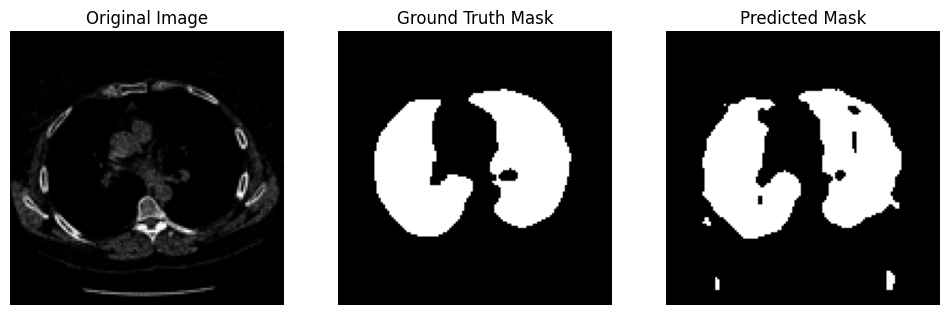

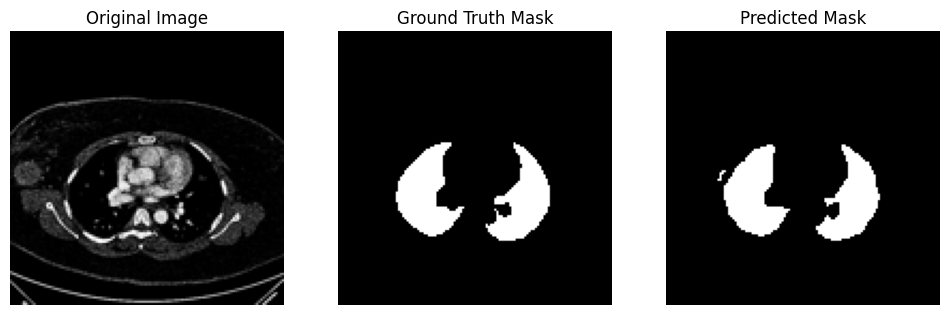

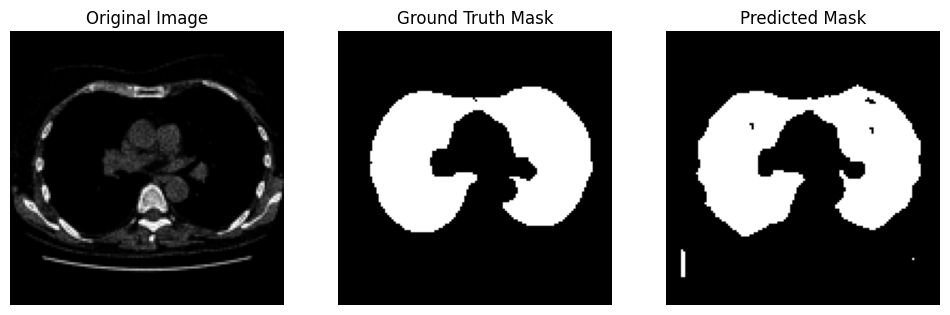

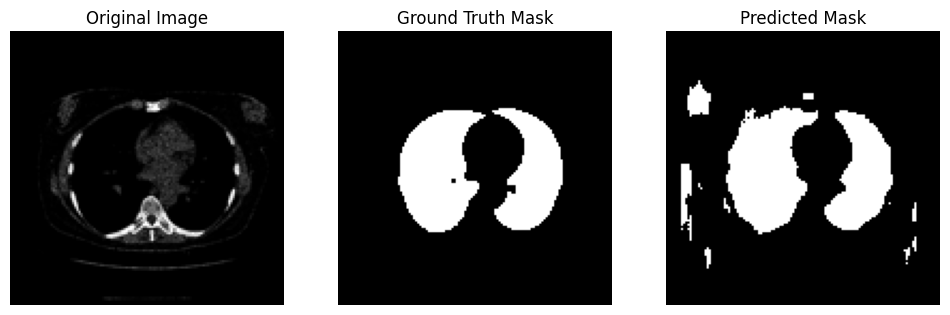

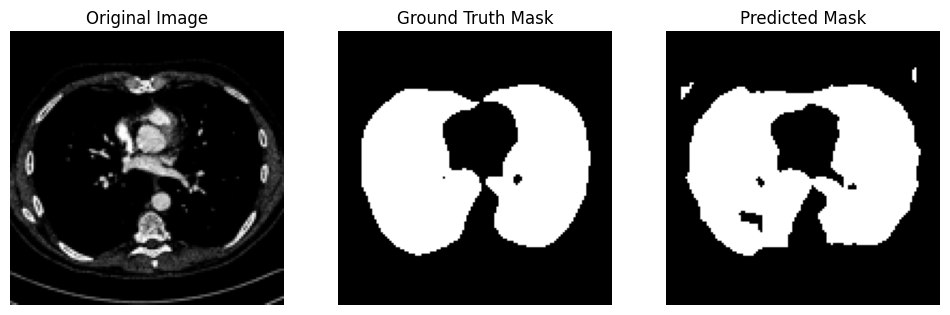

In [ ]:
import numpy as np
def visualize_lungs_predictions(model, X, y, num_samples=5):
    """
    Display original image, ground truth mask, and predicted mask for lungs.
    """
    preds = model.predict(X[:num_samples])
    preds_classes = np.argmax(preds, axis=-1)  # shape: (num_samples, H, W)

    for i in range(num_samples):
        plt.figure(figsize=(12,4))

        # Original CT image
        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1,3,2)
        plt.imshow(y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1,3,3)
        plt.imshow(preds_classes[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# ========================
# Usage example
# ========================
visualize_lungs_predictions(model, X_val, y_val, num_samples=5)



In [ ]:
!pip install segmentation-models==1.0.1 tensorflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00



Training History Metrics for Lungs U-Net:


,accuracy,dice_coefficient,iou_score,loss,val_accuracy,val_dice_coefficient,val_iou_score,val_loss
0,0.779536,0.648705,0.483466,0.516276,0.823702,0.740702,0.588517,0.408327
1,0.884504,0.813497,0.688628,0.289980,0.900970,0.823366,0.700160,0.256794
2,0.929897,0.891769,0.806111,0.175695,0.933998,0.904039,0.825296,0.165229
3,0.937567,0.905980,0.829470,0.160860,0.951518,0.928718,0.867640,0.133783
4,0.956317,0.934043,0.876606,0.115381,0.961237,0.933226,0.875442,0.113418


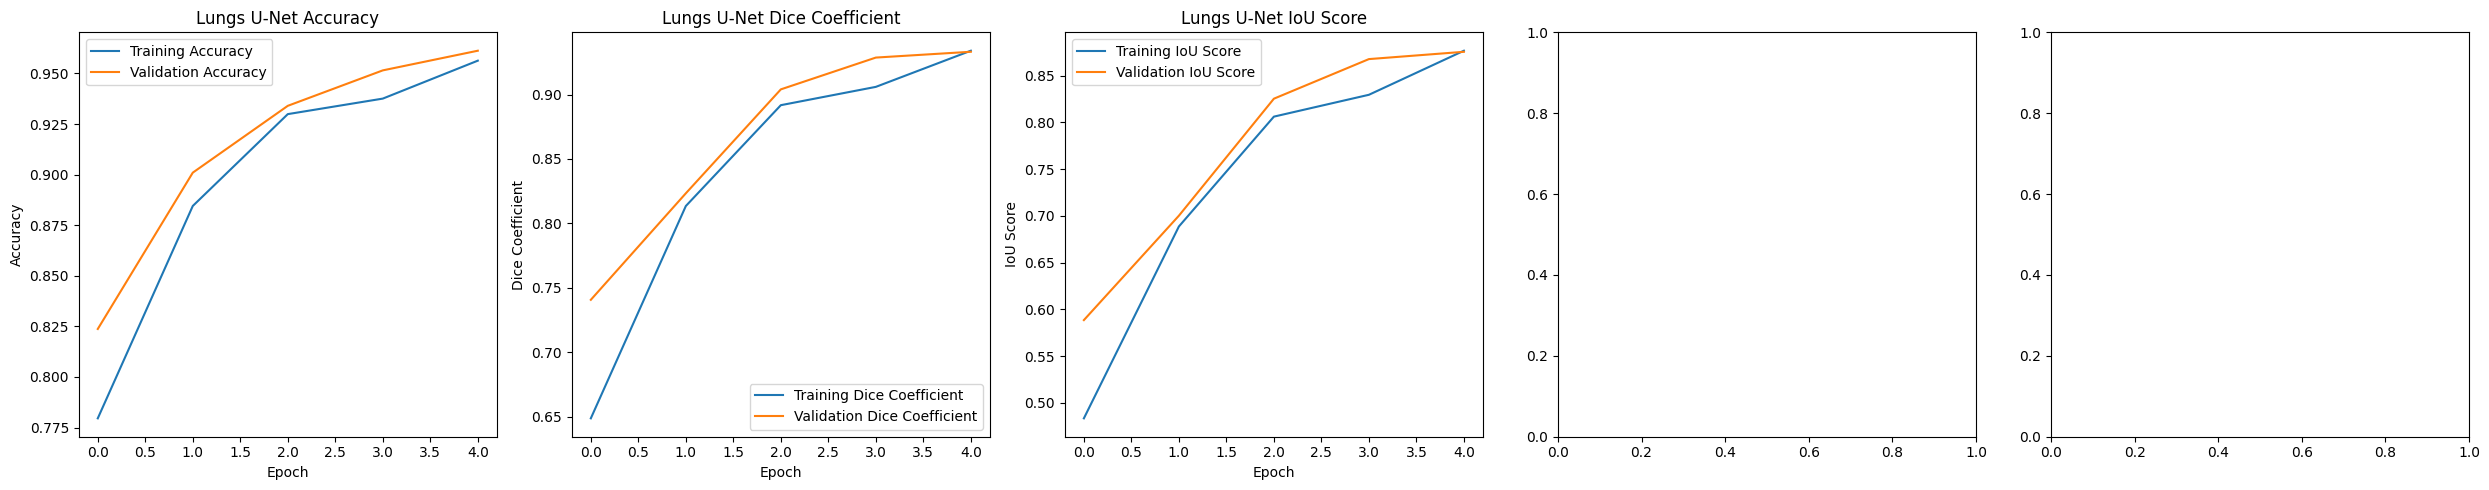

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ========================
# Function to plot training history with 5 metrics
# ========================
def plot_training_history(history, model_name="Model"):
    """
    history: Keras History object from model.fit()
    model_name: string, name of the model for plot titles
    """
    history_df = pd.DataFrame(history.history)
    print(f"\nTraining History Metrics for {model_name}:")
    display(history_df)

    # Prepare subplots
    plt.figure(figsize=(25, 5))

    metrics = [
        ('accuracy', 'Accuracy'),
        ('dice_coefficient', 'Dice Coefficient'),
        ('iou_score', 'IoU Score'),
        ('precision', 'Precision'),
        ('recall', 'Recall')
    ]

    for i, (metric_key, metric_name) in enumerate(metrics, start=1):
        plt.subplot(1, 5, i)
        if metric_key in history.history:
            plt.plot(history.history[metric_key], label=f'Training {metric_name}')
            plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {metric_name}')
            plt.title(f'{model_name} {metric_name}')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name)
            plt.legend()

    plt.tight_layout()
    plt.show()

# ========================
# Example Usage
# ========================
# For U-Net history
plot_training_history(history, model_name="Lungs U-Net")

